# Experiment 3: Spatial Features
Nachat Jatusripitak

In this notebook, we experiment with adding spatial features such as spatial neighborhood max, mean, etc.

In [ ]:
# Import required packages
import xgboost as xgb
import pandas as pd
import src.train_utils as T
import xarray as xr
import matplotlib.pyplot as plt

plt.style.use('ggplot')  

pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.width', None)

In [ ]:
# Load dataset
ds = xr.open_dataset('../datasets/exp_2_ds.nc')

# Hold out 2022
mask = ds.time.dt.year < 2022
ds_excl_2022 = ds.sel(time=mask)

# Add window average Delta PM2.5 (3-9 width)
for size in range(3, 9+1, 2):
  ds_excl_2022[f'delta_avg_{size}x{size}'] = (
      ds_excl_2022['delta_pm25_t']
        .rolling(i=size, j=size, center=True, min_periods=1)
        .mean()
  )

# Add window max Delta PM2.5 (3-9 width)
for size in range(3, 9+1, 2):
  ds_excl_2022[f'delta_max_{size}x{size}'] = (
      ds_excl_2022['delta_pm25_t']
        .rolling(i=size, j=size, center=True, min_periods=1)
        .max()
  )

# Add window average PM2.5 (3-9 width)
for size in range(3, 9+1, 2):
  ds_excl_2022[f'pm25_avg_{size}x{size}'] = (
      ds_excl_2022['pm25_t']
        .rolling(i=size, j=size, center=True, min_periods=1)
        .mean()
  )

# Add window max Delta PM2.5 (3-9 width)
for size in range(3, 9+1, 2):
  ds_excl_2022[f'pm25_max_{size}x{size}'] = (
      ds_excl_2022['pm25_t']
        .rolling(i=size, j=size, center=True, min_periods=1)
        .max()
  )

train_df = ds_excl_2022.to_dataframe().reset_index()

## Run 1: Cumulatively adding window mean $\Delta \text{PM}_{2.5}$

In [3]:
base = ['delta_pm25_t', 'delta_pm25_t-1', 'delta_pm25_t-2', 'delta_pm25_t-3', 'pm25_t', 'u_wind_t', 'v_wind_t',
       'dew_temp_t', 'temp_t', 'surf_pressure_t', 'precip_t',
       'frp_t', 'elevation_t', 'r_humidity_t']


params = {
    'max_depth': 4,            
    'learning_rate': 0.1,     
    'n_estimators': 150,     
    'subsample': 0.8,          
    'colsample_bytree': 0.8,   
    'objective': 'reg:pseudohubererror'   
}

feature_experiments = [('base', base)] + [
    (
        " + ".join(f"avg_{j}x{j}" for j in range(3, t+1, 2)),
        base + [f"delta_avg_{size}x{size}" for size in range(3, t+1, 2)]
    )
    for t in range(3, 9+1, 2)
]

model=xgb.XGBRegressor(**params, random_state=191)

results = T.run_experiments(
    df=train_df, 
    model=model, 
    feature_experiments=feature_experiments, 
    train_days=365*2,
    gap_days=21,
    val_days=49
)

print(results.sort_values('mean_rmse'))

  0%|          | 0/5 [00:00<?, ?it/s]

Running experiment: base


  0%|          | 0/10 [00:00<?, ?it/s]

Running experiment: avg_3x3


  0%|          | 0/10 [00:00<?, ?it/s]

Running experiment: avg_3x3 + avg_5x5


  0%|          | 0/10 [00:00<?, ?it/s]

Running experiment: avg_3x3 + avg_5x5 + avg_7x7


  0%|          | 0/10 [00:00<?, ?it/s]

Running experiment: avg_3x3 + avg_5x5 + avg_7x7 + avg_9x9


  0%|          | 0/10 [00:00<?, ?it/s]

                              experiment  n_features  mean_rmse  mean_mae  rmse_fold_1  rmse_fold_2  rmse_fold_3  rmse_fold_4  rmse_fold_5  rmse_fold_6  rmse_fold_7  rmse_fold_8  rmse_fold_9  rmse_fold_10
4  avg_3x3 + avg_5x5 + avg_7x7 + avg_9x9          18   4.315336  2.920081     1.630988     4.959289     5.070510     8.559132    13.242182     2.014808     0.906327     0.986028     1.816242      3.967858
2                      avg_3x3 + avg_5x5          16   4.325714  2.931542     1.658965     4.922441     5.080154     8.535922    13.277117     2.029681     0.911004     0.990706     1.838732      4.012414
3            avg_3x3 + avg_5x5 + avg_7x7          17   4.331561  2.930326     1.642861     4.932056     5.090826     8.548819    13.367299     2.023514     0.909284     0.989053     1.825234      3.986660
0                                   base          14   4.349951  2.954707     1.664721     4.967060     5.097207     8.597681    13.325319     2.052519     0.914111     0.991727   

                           experiment  mean_rmse
                              avg_3x3      4.358
                                 base      4.350
          avg_3x3 + avg_5x5 + avg_7x7      4.332
                    avg_3x3 + avg_5x5      4.326
avg_3x3 + avg_5x5 + avg_7x7 + avg_9x9      4.315


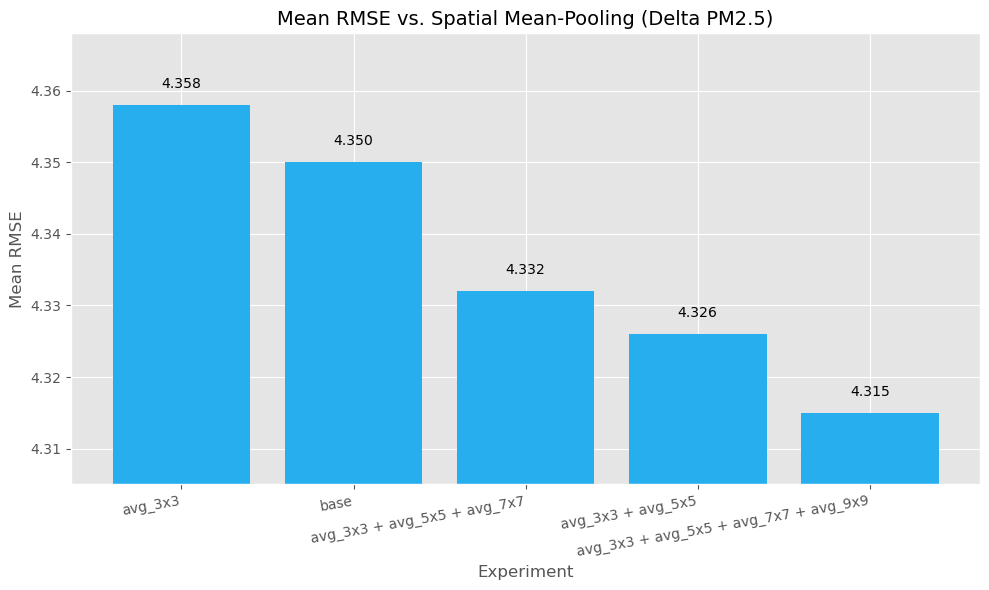

In [ ]:
df = results

# Sort by mean_rmse ascending
df_sorted = df.sort_values("mean_rmse", ascending=False)

# Display the sorted DataFrame (experiment and mean_rmse)
display_df = df_sorted[["experiment", "mean_rmse"]].copy()
display_df["mean_rmse"] = display_df["mean_rmse"].round(3)

print(display_df.to_string(index=False))

plt.figure(figsize=(10, 6))
bars = plt.bar(display_df["experiment"], display_df["mean_rmse"], color='#27aeef')
plt.ylim(display_df["mean_rmse"].min() - 0.01, display_df["mean_rmse"].max() + 0.01)
plt.xticks(rotation=10, ha="right")
plt.xlabel("Experiment", fontsize=12)
plt.ylabel("Mean RMSE", fontsize=12)

for bar, mean in zip(bars, display_df["mean_rmse"]):
    y = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, y + 0.002, f"{mean:.3f}", 
             ha='center', va='bottom', fontsize=10)

plt.title("Mean RMSE vs. Spatial Mean-Pooling (Delta PM2.5)", fontsize=14)

plt.tight_layout()
plt.show()


## Run 2: Cumulatively adding window mean $\text{PM}_{2.5}$

In [5]:
base = ['delta_pm25_t', 'delta_pm25_t-1', 'delta_pm25_t-2', 'delta_pm25_t-3', 'pm25_t', 'u_wind_t', 'v_wind_t',
       'dew_temp_t', 'temp_t', 'surf_pressure_t', 'precip_t',
       'frp_t', 'elevation_t', 'r_humidity_t']


params = {
    'max_depth': 4,            
    'learning_rate': 0.1,     
    'n_estimators': 150,     
    'subsample': 0.8,          
    'colsample_bytree': 0.8,   
    'objective': 'reg:pseudohubererror'   
}

feature_experiments = [('base', base)] + [
    (
        " + ".join(f"avg_{j}x{j}" for j in range(3, t+1, 2)),
        base + [f"pm25_avg_{size}x{size}" for size in range(3, t+1, 2)]
    )
    for t in range(3, 9+1, 2)
]

model=xgb.XGBRegressor(**params, random_state=191)

results = T.run_experiments(
    df=train_df, 
    model=model, 
    feature_experiments=feature_experiments, 
    train_days=365*2,
    gap_days=21,
    val_days=49
)

print(results.sort_values('mean_rmse'))

  0%|          | 0/5 [00:00<?, ?it/s]

Running experiment: base


  0%|          | 0/10 [00:00<?, ?it/s]

Running experiment: avg_3x3


  0%|          | 0/10 [00:00<?, ?it/s]

Running experiment: avg_3x3 + avg_5x5


  0%|          | 0/10 [00:00<?, ?it/s]

Running experiment: avg_3x3 + avg_5x5 + avg_7x7


  0%|          | 0/10 [00:00<?, ?it/s]

Running experiment: avg_3x3 + avg_5x5 + avg_7x7 + avg_9x9


  0%|          | 0/10 [00:00<?, ?it/s]

                              experiment  n_features  mean_rmse  mean_mae  rmse_fold_1  rmse_fold_2  rmse_fold_3  rmse_fold_4  rmse_fold_5  rmse_fold_6  rmse_fold_7  rmse_fold_8  rmse_fold_9  rmse_fold_10
4  avg_3x3 + avg_5x5 + avg_7x7 + avg_9x9          18   4.317625  2.929121     1.643137     4.882556     5.080274     8.476181    13.264721     2.030047     0.913943     0.995780     1.853109      4.036507
2                      avg_3x3 + avg_5x5          16   4.340360  2.945249     1.658180     4.918976     5.129748     8.548816    13.282225     2.043581     0.914023     0.993527     1.855440      4.059088
3            avg_3x3 + avg_5x5 + avg_7x7          17   4.343682  2.943208     1.653956     4.983131     5.097806     8.559794    13.296620     2.039999     0.916828     0.992835     1.852081      4.043769
0                                   base          14   4.349951  2.954707     1.664721     4.967060     5.097207     8.597681    13.325319     2.052519     0.914111     0.991727   

## Run 3: Cumulatively adding window max $\text{PM}_{2.5}$

In [6]:
base = ['delta_pm25_t', 'delta_pm25_t-1', 'delta_pm25_t-2', 'delta_pm25_t-3', 'pm25_t', 'u_wind_t', 'v_wind_t',
       'dew_temp_t', 'temp_t', 'surf_pressure_t', 'precip_t',
       'frp_t', 'elevation_t', 'r_humidity_t']


params = {
    'max_depth': 4,            
    'learning_rate': 0.1,     
    'n_estimators': 150,     
    'subsample': 0.8,          
    'colsample_bytree': 0.8,   
    'objective': 'reg:pseudohubererror'   
}

feature_experiments = [('base', base)] + [
    (
        " + ".join(f"max_{j}x{j}" for j in range(3, t+1, 2)),
        base + [f"pm25_max_{size}x{size}" for size in range(3, t+1, 2)]
    )
    for t in range(3, 9+1, 2)
]

model=xgb.XGBRegressor(**params, random_state=191)

results = T.run_experiments(
    df=train_df, 
    model=model, 
    feature_experiments=feature_experiments, 
    train_days=365*2,
    gap_days=21,
    val_days=49
)

print(results.sort_values('mean_rmse'))

  0%|          | 0/5 [00:00<?, ?it/s]

Running experiment: base


  0%|          | 0/10 [00:00<?, ?it/s]

Running experiment: max_3x3


  0%|          | 0/10 [00:00<?, ?it/s]

Running experiment: max_3x3 + max_5x5


  0%|          | 0/10 [00:00<?, ?it/s]

Running experiment: max_3x3 + max_5x5 + max_7x7


  0%|          | 0/10 [00:00<?, ?it/s]

Running experiment: max_3x3 + max_5x5 + max_7x7 + max_9x9


  0%|          | 0/10 [00:00<?, ?it/s]

                              experiment  n_features  mean_rmse  mean_mae  rmse_fold_1  rmse_fold_2  rmse_fold_3  rmse_fold_4  rmse_fold_5  rmse_fold_6  rmse_fold_7  rmse_fold_8  rmse_fold_9  rmse_fold_10
2                      max_3x3 + max_5x5          16   4.343244  2.954100     1.674654     4.917892     5.125646     8.535884    13.329102     2.045194     0.914963     0.993568     1.855721      4.039815
4  max_3x3 + max_5x5 + max_7x7 + max_9x9          18   4.348549  2.952707     1.674786     5.028594     5.098520     8.495287    13.360435     2.047834     0.915824     0.992830     1.854081      4.017302
0                                   base          14   4.349951  2.954707     1.664721     4.967060     5.097207     8.597681    13.325319     2.052519     0.914111     0.991727     1.853162      4.036003
3            max_3x3 + max_5x5 + max_7x7          17   4.351039  2.951092     1.672505     4.918397     5.098274     8.522681    13.457824     2.037835     0.915900     0.996003   

## Run 4: Cumulatively adding both window mean $\text{PM}_{2.5}, \Delta \text{PM}_{2.5}$

In [42]:
base = ['delta_pm25_t', 'delta_pm25_t-1', 'delta_pm25_t-2', 'delta_pm25_t-3', 'pm25_t', 'u_wind_t', 'v_wind_t',
       'dew_temp_t', 'temp_t', 'surf_pressure_t', 'precip_t',
       'frp_t', 'elevation_t', 'r_humidity_t']


params = {
    'max_depth': 4,            
    'learning_rate': 0.1,     
    'n_estimators': 150,     
    'subsample': 0.8,          
    'colsample_bytree': 0.8,   
    'objective': 'reg:pseudohubererror'   
}

feature_experiments = [('base', base)] + [
    ('base + 3x3', base + ["delta_avg_3x3", "pm25_avg_3x3"]),
    ('base + 3x3 + 5x5', base + ["delta_avg_3x3", "pm25_avg_3x3", "delta_avg_5x5", "pm25_avg_5x5"]),
    ('base + 3x3 + 5x5 + 7x7', base + ["delta_avg_3x3", "pm25_avg_3x3", "delta_avg_5x5", "pm25_avg_5x5", "delta_avg_7x7", "pm25_avg_7x7"]),
    ('base + 3x3 + 5x5 + 7x7 + 9x9', base + ["delta_avg_3x3", "pm25_avg_3x3", "delta_avg_5x5", "pm25_avg_5x5", "delta_avg_7x7", "pm25_avg_7x7", "delta_avg_9x9", "pm25_avg_9x9"]),
]

model=xgb.XGBRegressor(**params, random_state=191)

results = T.run_experiments(
    df=train_df, 
    model=model, 
    feature_experiments=feature_experiments, 
    train_days=365*2,
    gap_days=21,
    val_days=49
)

print(results.sort_values('mean_rmse'))

  0%|          | 0/5 [00:00<?, ?it/s]

Running experiment: base


  0%|          | 0/10 [00:00<?, ?it/s]

Running experiment: base + 3x3


  0%|          | 0/10 [00:00<?, ?it/s]

Running experiment: base + 3x3 + 5x5


  0%|          | 0/10 [00:00<?, ?it/s]

Running experiment: base + 3x3 + 5x5 + 7x7


  0%|          | 0/10 [00:00<?, ?it/s]

Running experiment: base + 3x3 + 5x5 + 7x7 + 9x9


  0%|          | 0/10 [00:00<?, ?it/s]

                     experiment  n_features  mean_rmse  rmse_fold_1  rmse_fold_2  rmse_fold_3  rmse_fold_4  rmse_fold_5  rmse_fold_6  rmse_fold_7  rmse_fold_8  rmse_fold_9  rmse_fold_10
4  base + 3x3 + 5x5 + 7x7 + 9x9          22   4.305515     1.628045     4.921942     5.070904     8.533576    13.221898     2.010702     0.907677     0.987360     1.818998      3.954049
3        base + 3x3 + 5x5 + 7x7          20   4.306909     1.642962     4.836926     5.089482     8.517203    13.221134     2.025471     0.910537     0.990027     1.829154      4.006194
2              base + 3x3 + 5x5          18   4.342617     1.654456     4.857598     5.097371     8.566828    13.453216     2.034858     0.911894     0.991204     1.839023      4.019717
1                    base + 3x3          16   4.347186     1.665710     4.971091     5.131628     8.600533    13.263844     2.046591     0.913420     0.991148     1.851475      4.036423
0                          base          14   4.349951     1.664721   

In [ ]:
# Export dataset with best features

for size in range(3, 9+1, 2):
  ds[f'delta_pm25_avg_{size}x{size}'] = (
      ds['delta_pm25_t']
        .rolling(i=size, j=size, center=True, min_periods=1)
        .mean()
  )

for size in range(3, 9+1, 2):
  ds[f'pm25_avg_{size}x{size}'] = (
      ds['pm25_t']
        .rolling(i=size, j=size, center=True, min_periods=1)
        .mean()
  )

ds = ds.dropna(dim="time", how="any")

ds.to_netcdf(
    "exp_3_ds.nc",
    format="NETCDF4",       # HDF5-backed NetCDF
    engine="netcdf4",      # or "netcdf4" if you have that
    encoding={
        var: {
            "zlib": True,
            "complevel": 4,
        }
        for var in ds.data_vars
    }
)